In [159]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
from pyrosm import OSM, get_data
from shapely.geometry import Point, Polygon
import numpy as np
import shapely
pd.options.mode.chained_assignment = None  # default='warn'

# Data analysis
Spatial analysis steps: 
* Determine locations of urban resource centers based on minimizing travel distance to material stock, using facility location method 
    * to do: pick facility location method
    * to do: find out how to use road network to calculate distance. start off with making a choropleth map showing how much material could be collected from each location within certain travel distances
* Determine areas suitable for urban resource centers according to spatial attributes (land price, land use) 
* Determine locations for different scenarios, by changing the travel distance limit. This allow for simulating urban resource centers at the neighborhood, city, regional, and national level

## 1. Read (already cleaned) data

In [160]:
# road network
nodes = gpd.read_file('data/roads/ams_nodes.shp')
edges = gpd.read_file('data/roads/ams_edges.shp')
G = ox.load_graphml('data/roads/ams_graph.graphml')

In [215]:
edges.osmid.map(lambda x: x.contains(', '))

AttributeError: 'str' object has no attribute 'contains'

In [ ]:
# edges - remove lists in columns in order to save shpfile
colsWithList = []
for col in edges.columns: 
    isList = edges[col].map(lambda x: isinstance(x, list))
    if isList.sum() >= 1: 
        colsWithList.append(col)
for col in colsWithList: 
    edges[col] = edges[col].map(lambda x: ', '.join([str(item) for item in x]) if isinstance(x, list) else str(x))

In [3]:
# gdf of supply of secondary resources 
supply = gpd.read_file('data/secondaryMaterialSupply/supply_NL.shp')
xmin, ymin, xmax, ymax = edges.total_bounds
supply = supply.cx[xmin:xmax, ymin:ymax]
supply = supply.reset_index(drop=True)

## 2. Calculate travel distance from A to B

Most (if not all) routing algorithms work more or less in a similar manner. The basic steps for finding an optimal route from A to B, is to:
 1. Find the nearest node for origin location (+ get info about its node-id and distance between origin and node)
 2. Find the nearest node for destination location (+ get info about its node-id and distance between origin and node)
 3. Use a routing algorithm to find the shortest path between A and B
 4. Retrieve edge attributes for the given route(s) and summarize them (can be distance, time, CO2, or whatever)
 
This same logic should be applied always when searching for an optimal route between a single origin to a single destination, or when calculating one-to-many -type of routing queries (producing e.g. travel time matrices). 

Origin node-id: 3187461411 and distance: 260.5027576809483 meters.
Destination node-id: 46409288 and distance: 330.03457040278386 meters.


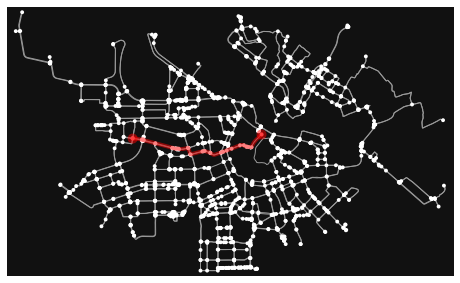

Text(0.5, 134.0786491889089, 'Shortest path distance  6547.6 meters (in 4.9 minutes)')

In [161]:
# find origin and destination coordinates (lat long) 
orig_address = "amsterdam central station, amsterdam" # origin: potential location for urban resource center 
orig_y, orig_x = ox.geocode(orig_address)  
origPt = gpd.GeoDataFrame(gpd.GeoSeries(Point(orig_x, orig_y)), geometry=0).set_crs('EPSG:4326').to_crs('EPSG:28992').rename(columns={0: 'geometry'}) # point for plotting
orig_y, orig_x = origPt.loc[0, 'geometry'].y, origPt.loc[0, 'geometry'].x
loc = 150 # dest: location of future material supply  
dest_y, dest_x = supply.loc[loc, 'geometry'].y, supply.loc[loc, 'geometry'].x 

# Find the closest nodes (on network graph) for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)
print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

# Calculate the paths 
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length') # list of nodes for path on graph
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')

# display
fig, ax = ox.plot_graph_route(G, metric_path)
ax.set_xlabel("Shortest path distance {t: .1f} meters (in{m: .1f} minutes)".format(t=travel_length, m=travel_length * 0.00075))

In [162]:
def makeGrid(cell_size): 
    # cell_size = 500
    # create square grid over NL according to cell size
    xmin, ymin, xmax, ymax = edges.total_bounds
    crs = "EPSG:28992"
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append(shapely.geometry.box(x0, y0, x1, y1))
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)

    # cut square grid into shape 
    boundary = gpd.GeoDataFrame(edges.geometry.buffer(1500), geometry=0, crs=crs).rename(columns={0: 'geometry'})
    mergeIndex = gpd.sjoin(boundary, cell, how='left', op='intersects').index_right.unique()
    grid = cell.loc[mergeIndex]
    grid = grid.reset_index(drop=True).reset_index()
    
    return grid

In [163]:
def calcKg(cell, distanceLimit, roadBuffer): 
    # print(cell)
    
    point = cell.centroid
    
    # snap location to closest node on road 
    orig_x, orig_y = point.x, point.y
    orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)

    # make ego graph for that node (an ego graph is a sub-graph that shows how far you can travel from specific node within a specific distance or time limit)
    egoGraph = nx.ego_graph(G, n=orig_node_id, radius=distanceLimit, distance='length')

    try: 
        # make isochrome from ego graph using bufferzones and combining them 
        nodesEgo, edgesEgo = ox.graph_to_gdfs(egoGraph)
        edgesEgo['bufferZone'] = edgesEgo.geometry.buffer(roadBuffer)
        isochrome = edgesEgo.bufferZone.unary_union

        # select points in supply that fit within the isochrome
        supply['inIso'] = supply.geometry.within(isochrome)
        supplyInIso = supply[supply.inIso == True]

        # summarize the total amount of materials in those points 
        supplyInIsoLong = pd.melt(supplyInIso, 
                              id_vars=['id', 'gridcode', 'buildYear', 'GFA', 'gebrWoonf', 'geometry'], 
                              value_vars=['steel', 'copper', 'aluminium', 'wood', 'concrete', 'brick', 'glass', 'ceramic', 'plastic', 'insulat'])
        supplyInIsoLong = gpd.GeoDataFrame(supplyInIsoLong)
        supplyInIsoLong.rename(columns={'variable': 'material', 'value': 'kg'}, inplace=True)
        materialSummary = supplyInIsoLong.groupby('material').sum().kg.reset_index()
    
    except: 
        return np.NaN
        
    return materialSummary.kg.sum()

In [210]:
nodes[nodes.osmid == nodeIds[3]]

,osmid,y,x,street_cou,highway,geometry
1177,3260832794,483918.681679,125361.178288,1,None,POINT (125361.178 483918.682)


In [213]:
edges[edges.v == nodeIds[3]]

,u,v,key,osmid,name,highway,maxspeed,oneway,length,bridge,ref,junction,width,lanes,tunnel,access,time_s,geometry
155,46252338,3260832794,0,"319644361, 479192363, 7044404",Voorlandpad,secondary,50.0,1,160.628,nan,None,None,"9.75, 8.5","4, 2, 3",None,None,11.565216,"LINESTRING (125277.281 483783.985, 125282.443 ..."


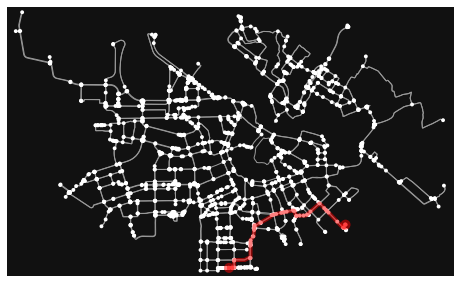

Text(0.5, 134.0786491889089, 'Shortest path distance  7979.7 meters (in 6.0 minutes)')

In [208]:
# Calculate the paths 
orig_node_id = 46178255
dest_node_id = nodeIds[3]
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length') # list of nodes for path on graph
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')

# display
fig, ax = ox.plot_graph_route(G, metric_path)
ax.set_xlabel("Shortest path distance {t: .1f} meters (in{m: .1f} minutes)".format(t=travel_length, m=travel_length * 0.00075))

In [205]:
nodeIds = []
for i in grid[grid.totKg.isna()].index: 
    cell = grid.loc[i, 'geometry']
    point = cell.centroid
    orig_x, orig_y = point.x, point.y
    orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
    nodeIds.append(orig_node_id)

print('{} problematic nodes: \n{}'.format(len(set(nodeIds)), set(nodeIds)))
nodes[nodes.osmid.isin(nodeIds)]

10 problematic nodes: 
{2004730915, 3078190532, 9102494883, 3785206371, 6219354473, 6068759179, 297103056, 8718272209, 3260832794, 46226556}


,osmid,y,x,street_cou,highway,geometry
57,46226556,483193.596541,122609.136103,1,None,POINT (122609.136 483193.597)
756,297103056,486777.740742,126619.074081,1,None,POINT (126619.074 486777.741)
1089,2004730915,486152.954500,113882.658973,1,None,POINT (113882.659 486152.955)
1170,3078190532,486552.032051,126852.857842,1,None,POINT (126852.858 486552.032)
1177,3260832794,483918.681679,125361.178288,1,None,POINT (125361.178 483918.682)
1234,3785206371,489590.059522,119993.659548,1,None,POINT (119993.660 489590.060)
1358,6068759179,489367.810666,120759.334359,1,None,POINT (120759.334 489367.811)
1366,6219354473,493222.269635,120581.248596,3,None,POINT (120581.249 493222.270)
1606,8718272209,487528.146633,126069.536600,1,None,POINT (126069.537 487528.147)
1615,9102494883,487411.303328,126041.318770,1,None,POINT (126041.319 487411.303)


In [181]:
edges[edges.v.isin(nodeIds)]

,u,v,key,osmid,name,highway,maxspeed,oneway,length,bridge,ref,junction,width,lanes,tunnel,access,time_s,geometry
113,46231954,46226556,0,139347133,Nieuwe Utrechtseweg,primary,50.0,1,102.417,nan,S110,None,nan,3,None,None,7.374024,"LINESTRING (122580.418 483291.878, 122598.123 ..."
155,46252338,3260832794,0,"319644361, 479192363, 7044404",Voorlandpad,secondary,50.0,1,160.628,nan,None,None,"9.75, 8.5","4, 2, 3",None,None,11.565216,"LINESTRING (125277.281 483783.985, 125282.443 ..."
1345,46578737,6219354473,0,"422656024, 664481425, 95596871",Verlengde Stellingweg,primary,50.0,1,138.882,nan,S118,None,nan,1,None,None,9.999504,"LINESTRING (120676.082 493164.427, 120671.292 ..."
2038,2004730847,2004730915,0,189868284,nan,secondary_link,50.0,1,40.384,nan,None,None,nan,nan,None,None,2.907648,"LINESTRING (113912.634 486179.387, 113908.158 ..."
2112,2117423916,6219354473,0,"664489232, 201724276",nan,primary_link,50.0,1,153.713,nan,None,None,nan,1,None,None,11.067336,"LINESTRING (120697.896 493172.208, 120689.410 ..."
2201,3078192343,3078190532,0,1040807283,nan,primary_link,50.0,1,53.999,nan,None,None,nan,2,None,None,3.887928,"LINESTRING (126842.624 486600.314, 126851.198 ..."
2459,5503380097,3785206371,0,"751641352, 375131156",Spaarndammerdijk,primary,50.0,1,330.252,nan,S102,None,6,"1, 2",None,None,23.778144,"LINESTRING (119663.023 489599.505, 119666.709 ..."
2543,6068759178,6068759179,0,525363801,Spaarndammertunnel,primary,50.0,1,33.318,nan,S102,None,nan,2,None,None,2.398896,"LINESTRING (120789.381 489353.838, 120779.785 ..."
3014,9047549744,297103056,0,977803836,IJburglaan,primary_link,50.0,1,32.781,nan,S114,None,nan,nan,None,None,2.360232,"LINESTRING (126607.993 486808.525, 126614.228 ..."
3026,9102494904,8718272209,0,984544884,nan,secondary_link,50.0,1,21.884,nan,None,None,nan,nan,None,None,1.575648,"LINESTRING (126091.113 487527.464, 126087.653 ..."


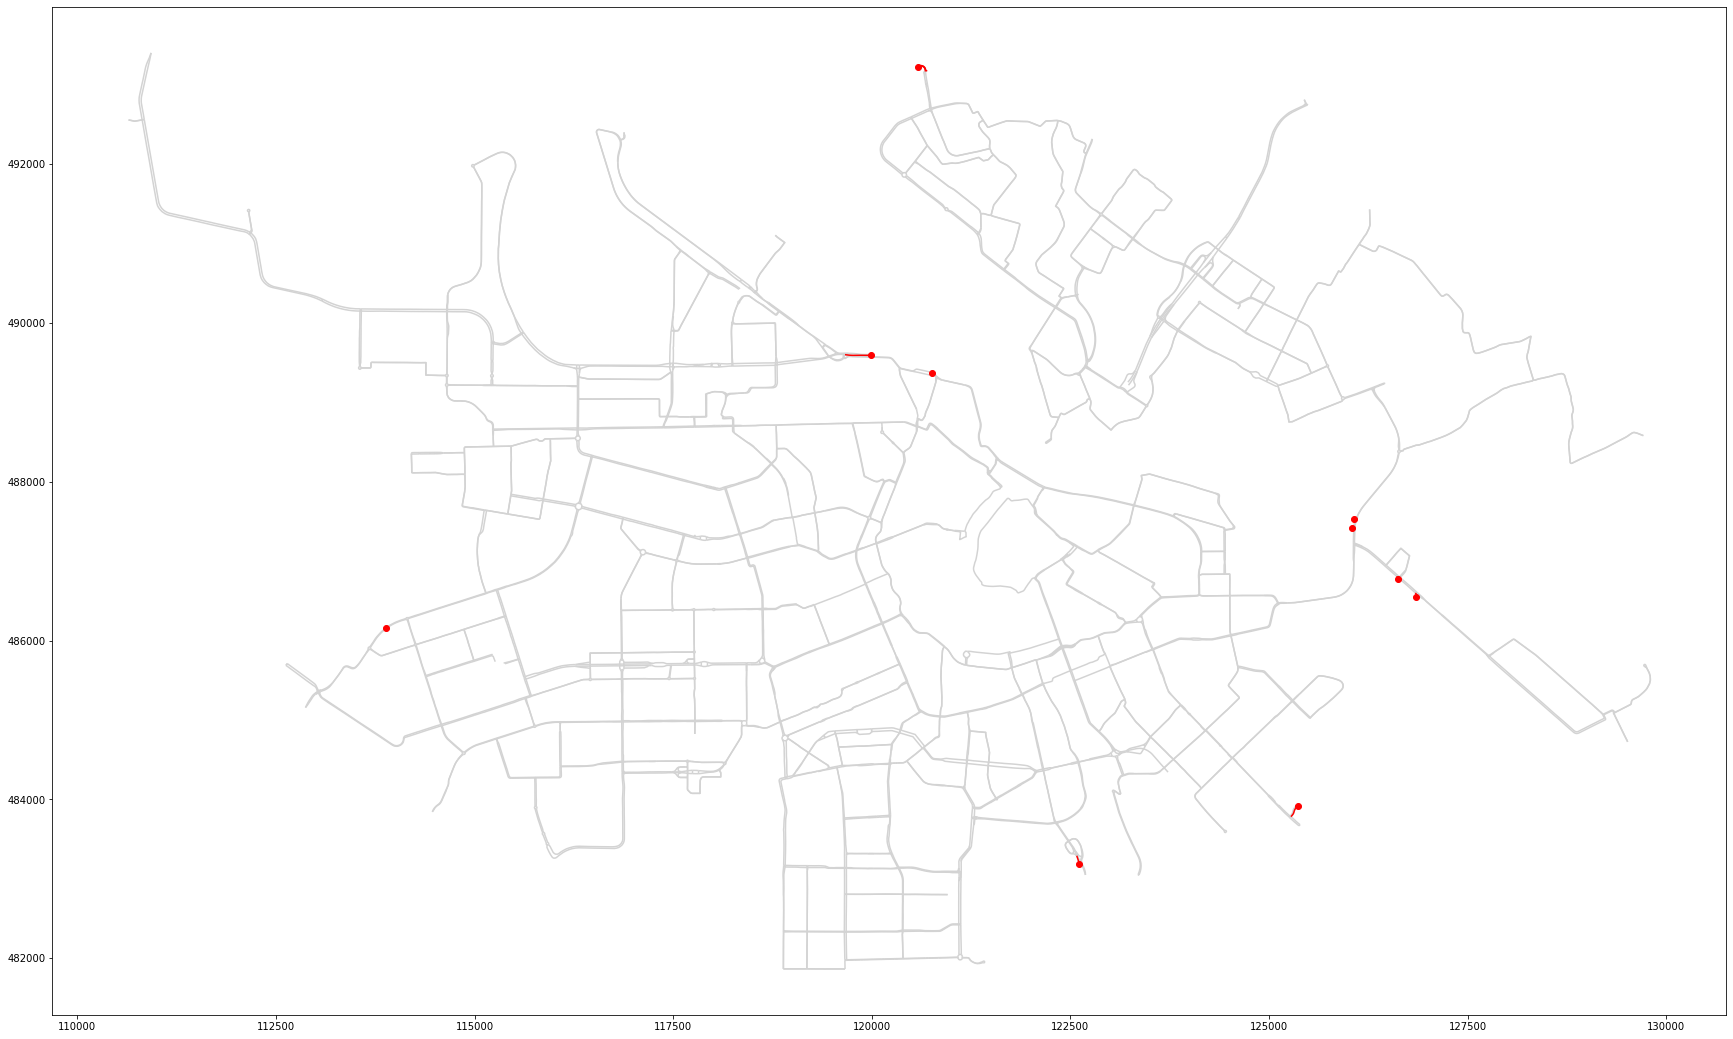

In [183]:
fig, ax = plt.subplots(1,1,figsize=(30,30))
edges.plot(ax=ax, color='lightgrey')
edges[edges.v.isin(nodeIds)].plot(ax=ax, color='red')
nodes[nodes.osmid.isin(nodeIds)].plot(ax=ax, color='red', zorder=10)
plt.show()

In [176]:
%%time
cellSize = 500
distanceLimit = 3000
roadBuffer = 1000

grid = makeGrid(cellSize)
grid['totKg'] = grid.geometry.map(lambda x: calcKg(x, distanceLimit, roadBuffer))

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\IPython\core\magics\execution.py:1316: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, glob, local_ns)


CPU times: total: 2min 28s
Wall time: 2min 30s


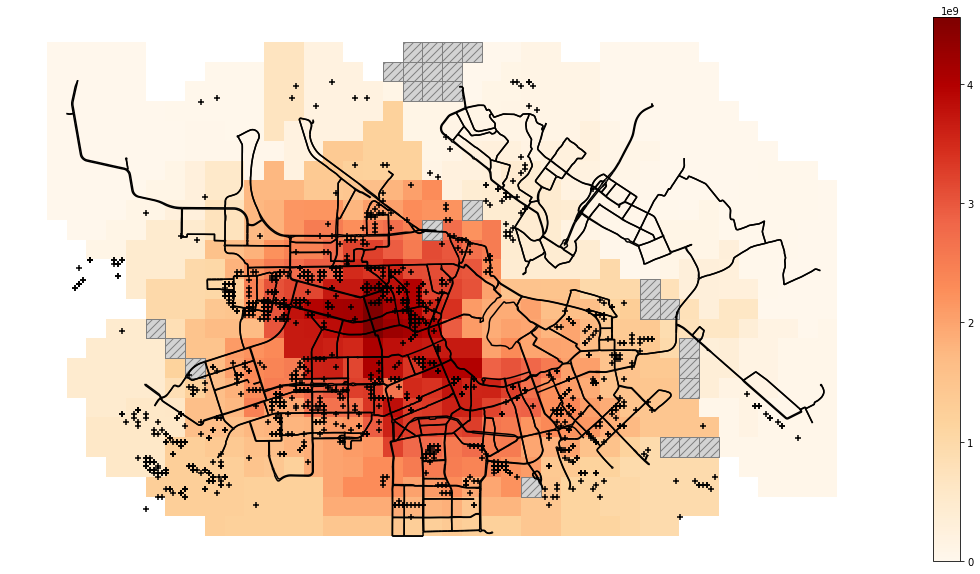

In [177]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
grid.plot(column='totKg', cmap='OrRd', legend=True, ax=ax, alpha=1, 
          missing_kwds={"color": "lightgrey", "edgecolor": "grey", "hatch": "///"})
edges.plot(ax=ax, color='black')
supply.plot(ax=ax, color='black', marker='+')
ax.axis('off')
plt.show()

aluminium: 4606 tonnes
brick: 119377 tonnes
ceramic: 8619 tonnes
concrete: 2039182 tonnes
copper: 450 tonnes
glass: 6041 tonnes
insulat: 23774 tonnes
plastic: 2260 tonnes
steel: 106816 tonnes
wood: 45780 tonnes

total: 2356904 tonnes


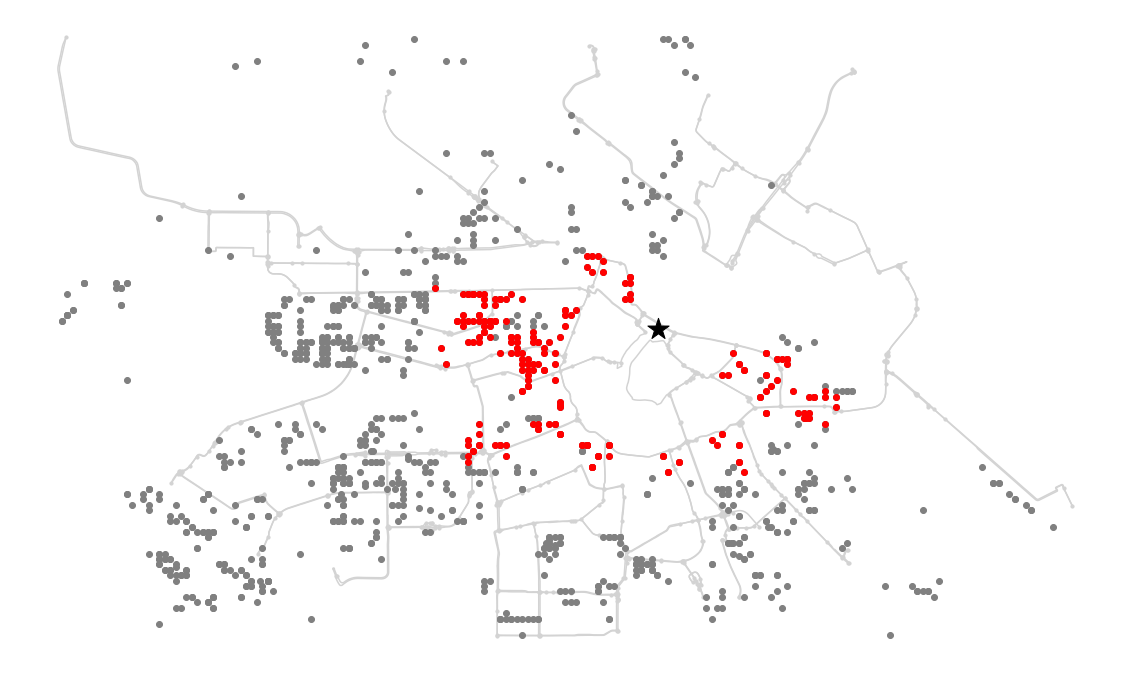

In [129]:
# set travel distance limit to 3km (as an example) 
distanceLimit = 5000
roadBuffer = 300

# for each location in Amsterdam grid: 
location  = origPt.loc[0, 'geometry']

# snap location to closest node on road 
orig_x, orig_y = location.x, location.y
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)

# make ego graph for that node (an ego graph is a sub-graph that shows how far you can travel from specific node within a specific distance or time limit)
egoGraph = nx.ego_graph(G, n=orig_node_id, radius=distanceLimit, distance='length')
# fig, ax = ox.plot_graph(egoGraph)

# make isochrome from ego graph using bufferzones and combining them 
nodesEgo, edgesEgo = ox.graph_to_gdfs(egoGraph)
edgesEgo['bufferZone'] = edgesEgo.geometry.buffer(roadBuffer)
isochrome = edgesEgo.bufferZone.unary_union

# select points in supply that fit within the isochrome
supply['inIso'] = supply.geometry.within(isochrome)
supplyInIso = supply[supply.inIso == True]

# summarize the total amount of materials in those points 
supplyInIsoLong = pd.melt(supplyInIso, 
                      id_vars=['id', 'gridcode', 'buildYear', 'GFA', 'gebrWoonf', 'geometry'], 
                      value_vars=['steel', 'copper', 'aluminium', 'wood', 'concrete', 'brick', 'glass', 'ceramic', 'plastic', 'insulat'])
supplyInIsoLong = gpd.GeoDataFrame(supplyInIsoLong)
supplyInIsoLong.rename(columns={'variable': 'material', 'value': 'kg'}, inplace=True)
materialSummary = supplyInIsoLong.groupby('material').sum().kg.reset_index()

# print stats
def display(row): 
    mat = row.material
    kg = row.kg
    print('{}: {} tonnes'.format(mat, round(kg / 1000)))
t = materialSummary.apply(lambda row: display(row), axis=1)
print('\ntotal: {} tonnes'.format(round(materialSummary.kg.sum() / 1000)))

# display
fig, ax = plt.subplots(1,1,figsize=(20,20))
nodes.plot(ax=ax, color='lightgrey', markersize=10)
edges.plot(ax=ax, color='lightgrey')
supply.plot(ax=ax, color='grey', zorder=10)
supplyInIso.plot(ax=ax, color='red', zorder=10)
origPt.plot(ax=ax, color='black', marker='*', markersize=500, zorder=10)
ax.axis('off')
plt.show()

## ?. Final result
* For now: choropleth map showing how much material could be collected from that location 
    * see [Maarten van Ham's research on job accessibility](https://www.researchgate.net/publication/299461295_Job_access_workplace_mobility_and_occupational_achievement)
* Choropleth map for different travel distance limits